In [35]:
import numpy as np
# TODO: 输入左心室的流量
time_series = np.loadtxt('time.txt')
P_AO_ref = np.loadtxt('p_ao.txt')
P_LA_ref = np.loadtxt('p_la.txt')
P_LV_ref = np.loadtxt('p_lv.txt')
V_LV_ref = np.loadtxt('v_lv.txt')
V_LA_ref = np.loadtxt('v_la.txt')

time_series = [t*1e-3 for t in time_series]  # 转换为毫秒
dt = time_series[1] - time_series[0]


def objective(params):
    P_LA_n = P_LA_ref[0]
    P_AO_n = P_AO_ref[0]
    P_LV_n = P_LV_ref[0]
    
    R_AV, R_MV, R_SYS, C_AO, C_LA,Q_MV_n, Q_SYS_n, Q_AV_n = params
    
    #  = 100,0,80
    
    matrix_2 = np.array([
        [0,      1,   0,        1/R_AV,               0,  -1/R_AV],
        [0,      0,   1,      -1/R_SYS,         1/R_SYS,        0],
        [1,      0,   0,             0,               0,        0],
        [-1,     0,   1,             0,        -C_LA/dt,        0],
        [0,      1,  -1,      -C_AO/dt,               0,        0],
        [1,     -1,   0,             0,               0,        0],
    ])
    matrix_inverse_2 = np.linalg.inv(matrix_2)

    matrix_3 = np.array([
        [0,      1,   0,             0,               0,       0],
        [0,      0,   1,      -1/R_SYS,         1/R_SYS,       0],
        [1,      0,   0,             0,         -1/R_MV,  1/R_MV],
        [-1,     0,   1,             0,        -C_LA/dt,       0],
        [0,      1,  -1,      -C_AO/dt,               0,       0],
        [1,     -1,   0,             0,               0,       0],
    ])
    matrix_inverse_3 = np.linalg.inv(matrix_3)

    matrix_4 = np.array([
        [0,      1,   0,        1/R_AV,               0,  -1/R_AV],
        [0,      0,   1,      -1/R_SYS,         1/R_SYS,       0],
        [1,      0,   0,             0,         -1/R_MV,  1/R_MV],
        [-1,     0,   1,             0,        -C_LA/dt,       0],
        [0,      1,  -1,      -C_AO/dt,               0,       0],
        [1,     -1,   0,             0,               0,       0],
    ])
    matrix_inverse_4 = np.linalg.inv(matrix_4)
    
    def advance(Q_LV, Q_MV_n, Q_AV_n, Q_SYS_n, P_LA_n, P_LV_n, P_AO_n, dt):
        Q_MV = Q_MV_n
        Q_AV = Q_AV_n
        Q_SYS = Q_SYS_n
        P_LA = P_LA_n
        P_LV = P_LV_n
        P_AO = P_AO_n
        rhs = np.array([0, 0, 0, -C_LA/dt*P_LA_n, -C_AO/dt*P_AO_n, Q_LV])
        # if P_LV > P_AO and P_LV > P_LA:
        result = np.dot(matrix_inverse_4, rhs)
        if P_LV < P_AO:
            result = np.dot(matrix_inverse_2, rhs)
        elif P_LA < P_LV:
            result = np.dot(matrix_inverse_3, rhs)
        Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV = result.flatten()
        return Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV

    # 初始化存储列表
    time_points = []
    P_LV_list = []
    P_AO_list = []
    P_LA_list = []
    Q_LV_list = []
    Q_AO_list = []
    Q_SYS_list = []

    for i in range(1275):
        time = i * dt
        Q_LV = (V_LV_ref[i+1] - V_LV_ref[i]) / dt  # 模拟一个周期内的流量变化
        # print(f"Time: {time}, Q_LV: {Q_LV}")
        # Q_LV = time  # 假设左心室流量为常数
        Q_MV, Q_AV, Q_SYS, P_AO, P_LA, P_LV= advance(Q_LV, Q_MV_n, Q_AV_n, Q_SYS_n, P_LA_n, P_LV_n, P_AO_n, dt)

        # 更新下一时刻的值
        Q_MV_n = Q_MV
        Q_AV_n = Q_AV
        Q_SYS_n = Q_SYS
        P_LA_n = P_LA
        P_LV_n = P_LV
        P_AO_n = P_AO
        
        # 存储数据
        time_points.append(time)
        P_LV_list.append(P_LV)
        P_AO_list.append(P_AO)
        P_LA_list.append(P_LA)
        Q_LV_list.append(Q_LV)
        Q_SYS_list.append(Q_SYS)
        Q_AO_list.append(Q_AV)
    
    sum = 0.0
    for i in range(1275):
        sum += ((P_LV_ref[i] - P_LV_list[i]))**2
        # +      ((P_LA_ref[i] - P_LA_list[i]))**2   +     ((P_AO_ref[i] - P_AO_list[i]))**2

    return sum




In [36]:
from scipy.optimize import minimize
initial_guess = [
    0.15,  # R_AV
    0.375,  # R_MV
    27,  # R_SYS
    0.06,  # C_AO
    0.02,  # C_LA
    100,  # Q_MV_n
    0.0,  # Q_SYS_n
    0.0   # Q_AV_n
]
result = minimize(objective, initial_guess, method='BFGS')  # 单纯形法
print("Nelder-Mead 结果:", result.x, result.fun)

# matrix_1 = np.array([
#     [0,      1,   0,             0,               0,  0],
#     [0,      0,   1,      -1/R_SYS,         1/R_SYS,  0],
#     [1,      0,   0,             0,               0,  0],
#     [-1,     0,   1,             0,        -C_LA/dt,  0],
#     [0,      1,  -1,      -C_AO/dt,               0,  0],
#     [1,     -1,   0,             0,               0,  0],
# ])
# matrix_inverse = np.linalg.inv(matrix_1)


Nelder-Mead 结果: [ 6.10243952e-02 -3.79092129e-02  9.24151189e+01  2.56166442e-01
  1.05863143e+00  1.00000000e+02  0.00000000e+00  0.00000000e+00] 9499792.017876545


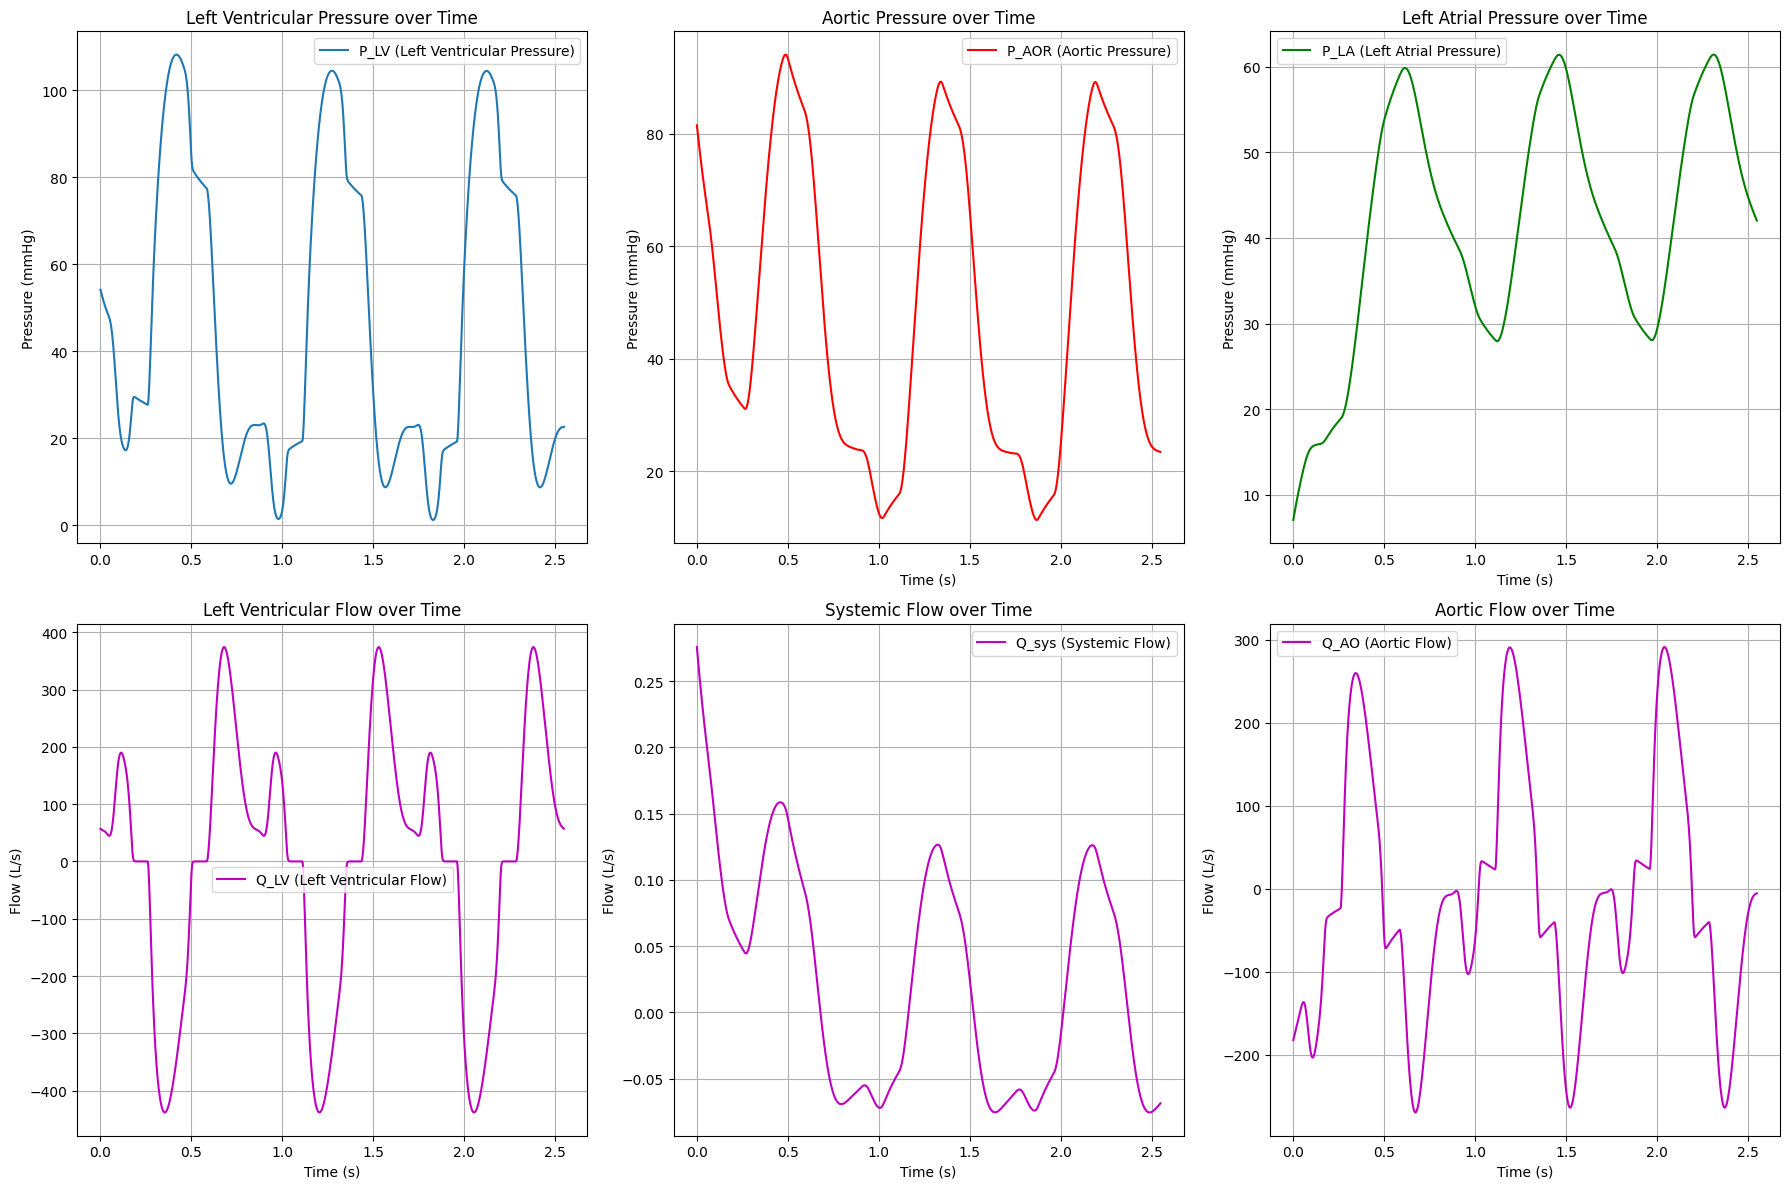

In [ ]:

import matplotlib.pyplot as plt
# 绘制图形
plt.figure(figsize=(18, 12))

# 绘制左心室压力
plt.subplot(2, 3, 1)
plt.plot(time_points, P_LV_list, label='P_LV (Left Ventricular Pressure)')
# plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Ventricular Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制主动脉压力
plt.subplot(2, 3, 2)
plt.plot(time_points, , 'r', label='P_AOR (Aortic Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Aortic Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制左心房压力
plt.subplot(2, 3, 3)
plt.plot(time_points, , 'g', label='P_LA (Left Atrial Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Atrial Pressure over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 4)
plt.plot(time_points, Q_LV_list, 'm', label='Q_LV (Left Ventricular Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Left Ventricular Flow over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 5)
plt.plot(time_points, Q_SYS_list, 'm', label='Q_sys (Systemic Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Systemic Flow over Time')
plt.grid(True)
plt.legend()

# 绘制左心室流量
plt.subplot(2, 3, 6)
plt.plot(time_points, Q_AO_list, 'm', label='Q_AO (Aortic Flow)')
plt.xlabel('Time (s)')
plt.ylabel('Flow (L/s)')
plt.title('Aortic Flow over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
# plt.show()
plt.savefig("LV_hyper_dynamic_results.png")

In [148]:
P_AO = np.loadtxt('p_ao.txt')
P_LA = np.loadtxt('p_la.txt')
P_LV = np.loadtxt('p_lv.txt')
V_LV = np.loadtxt('v_lv.txt')
V_LA = np.loadtxt('v_la.txt')

1276 1276 1276


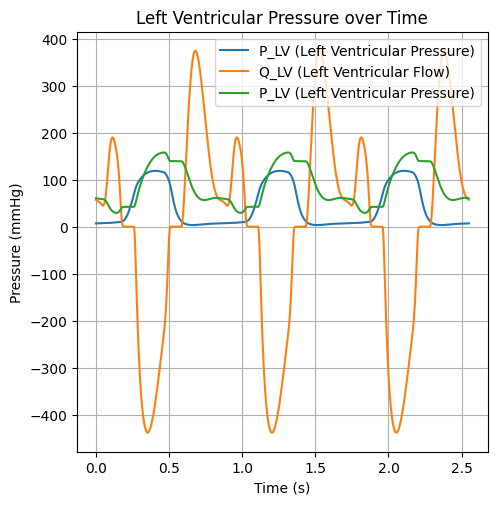

In [149]:
import matplotlib.pyplot as plt
# 绘制图形
plt.figure(figsize=(18, 12))

Q_LV = [(V_LV[i+1] - V_LV[i]) / dt for i in range(len(V_LV)-1)]
Q_LV.append(Q_LV[-1])  # 保持长度一致
print(len(Q_LV), len(time_series), len(P_LV))

# 绘制左心室压力
plt.subplot(2, 3, 1)
plt.plot(time_series, P_LV, label='P_LV (Left Ventricular Pressure)')
plt.plot(time_series, Q_LV, label='Q_LV (Left Ventricular Flow)')
plt.plot(time_points, P_LV_list, label='P_LV (Left Ventricular Pressure)')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (mmHg)')
plt.title('Left Ventricular Pressure over Time')
plt.grid(True)
plt.legend()

plt.show()